In [1]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage


In [2]:
import os
 
os.environ["AZURE_OPENAI_API_KEY"] = "0bf3daeba1814d03b5d62e1da4077478"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://openaisk123.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-08-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"] = "gpt-4o"

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [4]:
from IPython.display import Image, display

class Agent:
    def __init__(self, model, checkpointer, system_developer="", system_validator="", system_corrector=""):
        self.system_developer = system_developer
        self.system_validator = system_validator
        self.system_corrector = system_corrector

        graph = StateGraph(AgentState)
        
        graph.add_node("developer", self.developer)
        
        graph.add_node("validator", self.validator)  
        graph.add_node("correction", self.correction)

        graph.add_edge("developer", "validator")

     
        graph.add_conditional_edges("validator", lambda state: state["is_valid"], {
        True: END,
        False: "correction"
        })


        graph.add_edge("correction", END)

        graph.set_entry_point("developer")
        self.graph = graph.compile(checkpointer = checkpointer)
        self.model = model


        try:
            display(Image(self.graph.get_graph().draw_mermaid_png()))
        except Exception:
            pass


    def developer(self, state: AgentState):
        messages = state['messages']
        print(messages)
        print("developer","*" * 50)
        if self.system_developer:
            messages = [SystemMessage(content=self.system_developer)] + messages
        message = self.model.invoke(messages)
        # print("developer: ",message)
        return {'messages': [message]}
    
    def validator(self, state: AgentState):
        messages = state.get("messages", [])
        print(messages)

        print("validate","*" * 50)


        if self.system_validator:
            messages = [SystemMessage(content=self.system_validator)] + messages

        message = self.model.invoke(messages)
        response_text = getattr(message, "content", "").lower()

        is_valid = "correctly reflects" in response_text and "no contradictions" in response_text
        res = {"is_valid": is_valid, "messages": [message]}  
        return res



    def correction(self, state: AgentState):
        messages = state['messages']
        print(messages)

        print("correction","*" * 50)

        if self.system_corrector:
            messages = [SystemMessage(content=self.system_corrector)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

In [5]:
user_story_prompt = """
Role: You are an expert in software requirements analysis and agile methodology. Your task is to **convert a business requirement into multiple well-structured user stories**, ensuring clarity, completeness, and alignment with best practices.  

### **TASK:**  
1. **Analyze the Business Requirement**: Extract key functionalities, user roles, and expected outcomes.  
2. **Generate Multiple User Stories**: Break down the requirement into multiple **independent, actionable user stories** covering different aspects of the functionality.  
3. **Define Acceptance Criteria for Each**: Ensure that every user story has measurable and testable acceptance criteria.  
4. **Maintain Structure**: Follow the predefined user story format strictly.  

### **STRICT INSTRUCTIONS:**  
- **DO NOT** include any additional explanations or commentary.  
- **ENSURE** each user story is specific, actionable, and testable.
- **GENERATE** as max as possible user stories.  
- **DISPLAY** all of the generated user stories dont truncate them for brevity
- **USE ONLY** the following format for each user story:  

---
### **User Story Format**  
User Story X:  
**Module:** [Extracted Module Name]  
**Feature:** [Extracted Feature Name]  
**User Story ID:** [Generated Unique ID]  
**User Story:** [Clearly defined user story]  
**Description:** As a [user type], I want to [action] so that I can [goal or benefit].  

**Acceptance Criteria:**  
1. [First clear and testable acceptance criterion]  
2. [Second clear and testable acceptance criterion]  
3. [Third clear and testable acceptance criterion]  
---

### **BUSINESS REQUIREMENT:**  
{}

"""



validator_prompt = """
Role: You are an expert in refining and correcting software requirements. Your task is to **analyze and provide structured feedback** on the generated user stories to ensure clarity, accuracy, and completeness.  

### **TASK:**  
1. **Identify Errors**: Highlight any inaccuracies, inconsistencies, or misinterpretations.  
2. **Suggest Improvements**: Recommend ways to enhance clarity, readability, and eliminate ambiguities.  
3. **Ensure Completeness**: Point out any missing details related to user actions, system behavior, edge cases, or constraints.  
4. **Verify Alignment with Business Requirement**: Ensure each user story is faithful to the original requirement.  

### **STRICT INSTRUCTIONS:**  
- **DO NOT** rewrite or correct the user stories.  
- **DO NOT** output nonsensical content—provide structured and meaningful feedback.  
- **ONLY** return structured feedback in the following format:  


### **Feedback Format**  
**Issue:** [Description of the issue]  
**Severity:** [Critical / Major / Minor]  
**Suggested Improvement:** [Actionable suggestion]  


### **BUSINESS REQUIREMENT:**  
{}  

### **ORIGINAL USER STORIES:**  
{} 
"""



corrector_prompt = """
Role: You are an expert in refining and correcting software requirements. Your task is to **improve and correct** user stories based on validation feedback to ensure clarity, accuracy, and completeness.  

### **TASK:**  
1. **Apply Corrections**: Fix all identified errors, inconsistencies, and ambiguities highlighted in the validator's feedback.  
2. **Enhance Clarity**: Reword or restructure statements to improve readability while maintaining technical accuracy.  
3. **Ensure Completeness**: Incorporate any missing details related to user actions, system behavior, edge cases, or constraints.  
4. **Align with Business Requirement**: Ensure the refined user stories remain faithful to the original business requirement while integrating necessary corrections.  

### **STRICT INSTRUCTIONS:**  
- **DO NOT** include summaries, explanations, or additional commentary.  
- **DO NOT** truncate the output for brevity.
- **DO NOT** provide validation feedback—only return the corrected user stories.  
- **ENSURE** that the response is clear, well-structured, and fully aligned with the business requirement. 
- **INCLUDE** user stories for error handling to address issues like invalid data, network failures, and system downtime.
- **RETURN ALL** the corrected user stories and userstories generted by developer in the following format:


### **Corrected User Stories Format**  
User Story X:  
**Module:** [Updated Module Name]  
**Feature:** [Updated Feature Name]  
**User Story ID:** [Updated Unique ID]  
**User Story:** [Refined user story]  
**Description:** As a [user type], I want to [action] so that I can [goal or benefit].  

**Acceptance Criteria:**  
1. [First clear and testable acceptance criterion]  
2. [Second clear and testable acceptance criterion]  
3. [Third clear and testable acceptance criterion]  


### **BUSINESS REQUIREMENT:**  
{}  

### **VALIDATOR FEEDBACK:**  
{}   

### **ORIGINAL USER STORIES:**  
{} 
"""

from langchain_openai import AzureChatOpenAI
model = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"],
)



In [6]:
breq = """**Business Requirement Document**

### **Introduction**
This document outlines the key business requirements for data management, AI model deployment, and cloud services integration. The primary focus is to ensure seamless data handling, model training, and inferencing to support AI-driven decision-making processes.

### **Business Requirements**

#### **1. Data Management and Transfer**
**Objective:** Users should be able to efficiently upload, store, and retrieve image and dataset files for AI training and inferencing.
- Users should have an intuitive interface to upload training datasets stored locally or on external drives.
- The uploaded data should automatically be structured according to AI model requirements.
- Users should receive clear messages regarding data errors, such as unsupported file formats, incomplete datasets, or storage issues.
- Users should be able to retrieve DICOM images and reports from PACS servers by specifying a valid Patient ID.
- The system must validate image data before storing or processing it to ensure data quality.

#### **2. Cloud Storage and Management**
**Objective:** Users should have secure and organized cloud storage solutions for AI model files, reports, and data.
- Users should be able to configure cloud storage services such as AWS or Azure directly through a user interface.
- Storage buckets should be automatically created for distinct purposes like training datasets, test datasets, and model artifacts.
- If a selected cloud service or credentials are invalid, appropriate error messages should be displayed.
- Users should have the ability to upload, download, and manage data directly through the configured cloud service.

#### **3. Model Training and Optimization**
**Objective:** Users should be able to train, optimize, and manage machine learning models efficiently.
- Users should initiate model training by referencing a valid dataset stored in the cloud.
- The system must automatically optimize models for different hardware configurations like GPU and CPU to improve performance.
- If optimization is not required (e.g., model is already in the required format), the system should skip the optimization process.
- The system should support version control to allow users to track different iterations of their models.

#### **4. Model Deployment and Inference**
**Objective:** Users should be able to deploy optimized models seamlessly for inference tasks.
- The system should automatically load the latest available model in the inference container to ensure optimal performance.
- Users should also have the option to specify a particular model version for deployment.
- If no valid model ID is provided, the system should prompt the user for correction.
- Users should have control over running inference using either CPU or GPU, with the system defaulting to GPU for larger workloads if available.

#### **5. Reporting and Record Maintenance**
**Objective:** Users should have access to patient data, DICOM Structured Reports (SR), and AI result records.
- Users should be able to retrieve reports based on valid Patient IDs.
- The system should ensure that retrieved reports are up to date and allow users to download multiple reports at once.
- The system should maintain all patient data, image URIs, and PDF reports in a secure NoSQL database.

#### **6. Cloud Service Integration**
**Objective:** Users should be able to create, configure, and manage cloud infrastructure for AI services.
- The system should automatically configure IAM roles and policies to manage cloud permissions securely.
- Cloud instances must be created with GPU capabilities for enhanced AI processing.
- If errors occur in cloud formation scripts, users should be notified with clear instructions on corrective actions.

### **Conclusion**
This business requirement document is intended to provide a clear understanding of the expected functionalities and objectives. By ensuring structured data management, optimized model handling, and robust cloud integration, this system aims to enhance user efficiency and support advanced AI model workflows.

 """

messages = [HumanMessage(content=breq)]


In [7]:
# breq = """•Projects proposed based on key features in recent Qualcomm product launches with a clear emphasis on developer value creation. They are discussed, shortlisted and approved by customer during weekly calls
# •Shorts projects with a duration of 8-12 weeks are proposed and executed in Agile Methodology. Incremental features are added at later stages
# •Recent projects have had a heavy focus on AI/ML, Robotics, GenAIthemes. These projects were executed by expert AI/ML team from GlobalEdge, Capgemini
# •Project status, requirements compliance and stability discussed and demonstrated during weekly calls
# •Completed projects along with relevant project documentation are uploaded first to GlobalEdgeGitHub repo which are then reviewed and uploaded to Qualcomm GitHub repo by the customer post Qualcomm internal review.
# •Some of these projects were demonstrated by customer at Qualcomm booths at various tradeshows participated in 2024
#  """
# messages = [HumanMessage(content=breq)]


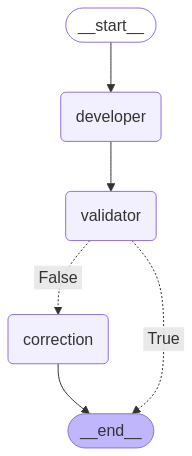

[HumanMessage(content='**Business Requirement Document**\n\n### **Introduction**\nThis document outlines the key business requirements for data management, AI model deployment, and cloud services integration. The primary focus is to ensure seamless data handling, model training, and inferencing to support AI-driven decision-making processes.\n\n### **Business Requirements**\n\n#### **1. Data Management and Transfer**\n**Objective:** Users should be able to efficiently upload, store, and retrieve image and dataset files for AI training and inferencing.\n- Users should have an intuitive interface to upload training datasets stored locally or on external drives.\n- The uploaded data should automatically be structured according to AI model requirements.\n- Users should receive clear messages regarding data errors, such as unsupported file formats, incomplete datasets, or storage issues.\n- Users should be able to retrieve DICOM images and reports from PACS servers by specifying a valid Pat

In [8]:
thread = {"configurable": {"thread_id": "1"}}
from langgraph.checkpoint.sqlite import SqliteSaver
with SqliteSaver.from_conn_string(":memory:") as checkpointer:
    abot = Agent(model, system_developer=user_story_prompt, system_validator=validator_prompt, system_corrector=corrector_prompt,checkpointer=checkpointer)    
    for event in abot.graph.stream({"messages": messages},thread):
            for v in event.values():
                print(v['messages'][0].content)